# 3A.mr - Map/Reduce avec PIG sur Azure - énoncé

Manipulation de fichiers sur un cluster Hadoop [HDInsight](https://azure.microsoft.com/en-us/services/hdinsight/), premieer job map/reduce avec [PIG](https://pig.apache.org/). Lire aussi [From Pig to Spark: An Easy Journey to Spark for Apache Pig Developers](https://mapr.com/blog/easy-journey-from-pig-to-spark-for-developers/).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

Dans le cadre du [partenariat avec Microsoft](http://www.microsoft.com/france/Hub-Presse/communiques-de-presse/fiche-communique.aspx?eid=f7e7f695-fb08-4c6d-b4ec-3cde562ba429), l'ENSAE dispose de ressources Azure. Azure est une plateforme qui propose de nombreux [fonctionnalités et services](http://azure.microsoft.com/fr-fr/services/cloud-services/). Les élèves n'auront pas directement accès au portail Azure mais recevront les identifiants et mots de passe pour les services mis en place à leur intention. Ils seront différents selon les services mais ce sera le même identifiant pour chaque élève.

Cette séance de travaux pratique s'appuiera sur le jeu de données suivant : [Localization Data for Person Activity Data Set](https://archive.ics.uci.edu/ml/datasets/Localization+Data+for+Person+Activity) qu'on récupère comme suit :

In [3]:
import pyensae
import urllib.error
try:
    # ce soir ça ne marche pas...
    pyensae.download_data("ConfLongDemo_JSI.txt", 
                          website="https://archive.ics.uci.edu/ml/machine-learning-databases/00196/")
except urllib.error.URLError:
    # donc je récupère une vieille copie
    pyensae.download_data("ConfLongDemo_JSI.zip")

On l'insère dans une base de données SQL.

In [4]:
columns = "sequence tag timestamp dateformat x y z activity".split()
import pandas, sqlite3, os
df = pandas.read_csv("ConfLongDemo_JSI.txt", sep=",", names=columns)
if os.path.exists("ConfLongDemo_JSI.db3"):
    os.remove("ConfLongDemo_JSI.db3")
con = sqlite3.connect("ConfLongDemo_JSI.db3")
df.to_sql("person", con)
con.close()
df.head()

,sequence,tag,timestamp,dateformat,x,y,z,activity
0,A01,010-000-024-033,633790226051280329,27.05.2009 14:03:25:127,4.062931,1.892434,0.507425,walking
1,A01,020-000-033-111,633790226051820913,27.05.2009 14:03:25:183,4.291954,1.781140,1.344495,walking
2,A01,020-000-032-221,633790226052091205,27.05.2009 14:03:25:210,4.359101,1.826456,0.968821,walking
3,A01,010-000-024-033,633790226052361498,27.05.2009 14:03:25:237,4.087835,1.879999,0.466983,walking
4,A01,010-000-030-096,633790226052631792,27.05.2009 14:03:25:263,4.324462,2.072460,0.488065,walking


On crée un petit exemple pour plus tard qu'on enregistre également dans la base de données.

In [6]:
columns = "sequence tag timestamp dateformat x y z activity".split()
import pandas
df = pandas.read_csv("ConfLongDemo_JSI.txt", sep=",", names=columns)
dfs = df[:1000]
dfs.to_csv("ConfLongDemo_JSI.small.txt", header=False)

import sqlite3
con = sqlite3.connect("ConfLongDemo_JSI.db3")
dfs.to_sql("person_small", con)
con.close()

## Partie 0 : aperçu de Azure HDInsight
    
Il faut se connecter au cluster avec l'url : ``https://....datascience.fr/....&login=<login>``.

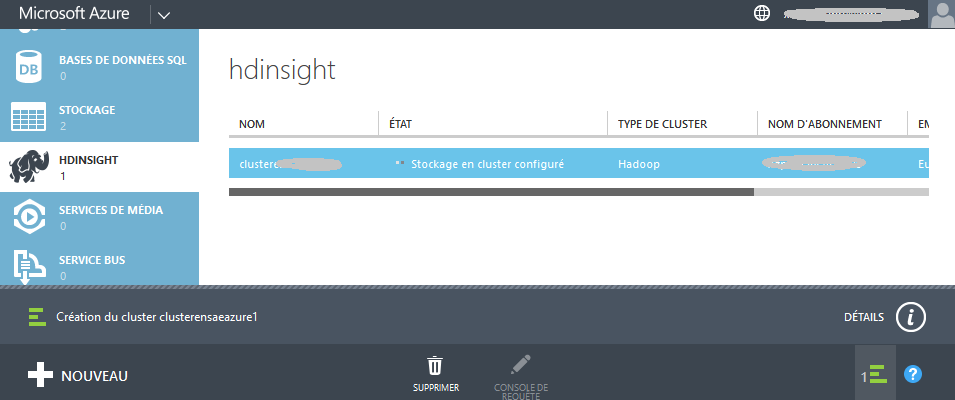

In [7]:
from pyquickhelper.helpgen import NbImage
NbImage("clhdins.png", width=600)

On peut accéder à ce cluster via une adresse web qui s'ouvre sur la fenêtre suivante d'où on peut voir le contenu des fichiers et

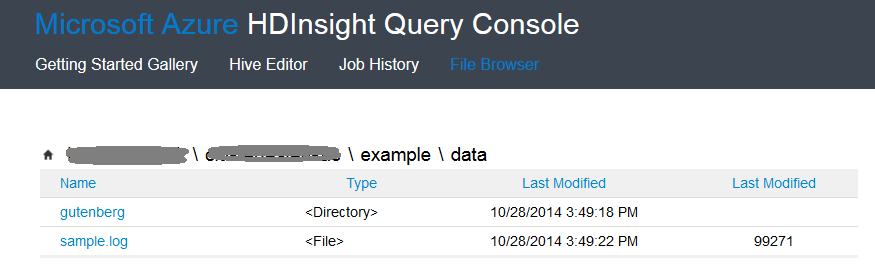

In [9]:
NbImage("clhdins2.png", width=600)

Le fenêtre suivante permet d'effectuer des requêtes distribuées avec le langage [Hive](https://hive.apache.org/) très proche du SQL.

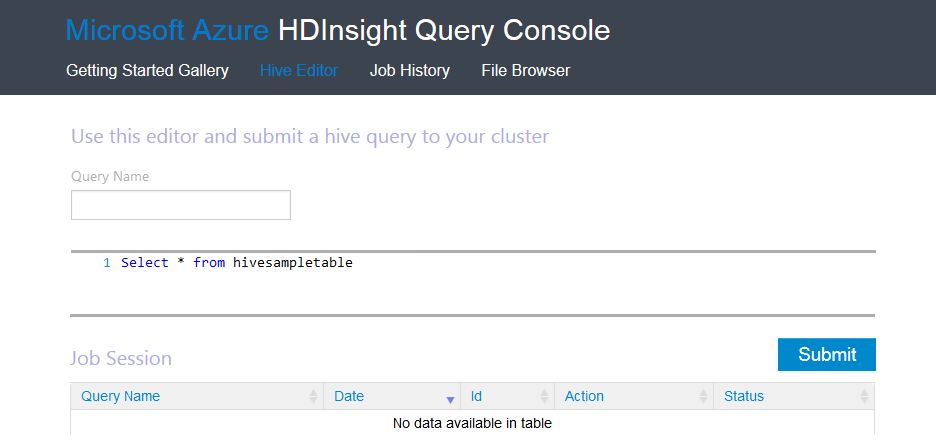

In [11]:
NbImage("clhdins3.png", width=600)

## Partie 1 :  manipulation de fichiers

Avant de commencer à déplacer des fichiers, il faut comprendre qu'il y a trois entités :

* l'ordinateur local (celui dont vous vous servez)
* le stockage : [Azure Blob Storage](http://azure.microsoft.com/en-us/documentation/articles/storage-dotnet-how-to-use-blobs/)
* le cluster  [Hadoop](http://fr.hortonworks.com/)

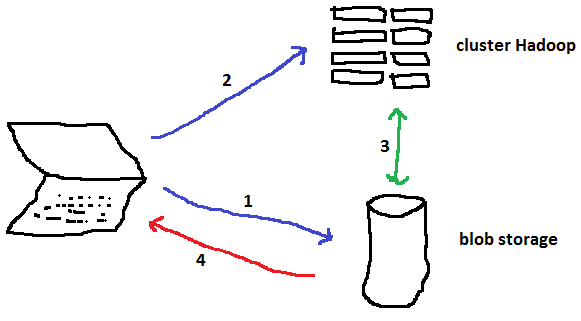

In [13]:
from IPython.core.display import Image
NbImage("azure3.png")

Pour exécuter une tâche Map/Reduce, il faut suivre le processus suivant :

* 1a : on communique avec l'Azure Blob Storage pour **uploader** les données avec lesquelles on va travailler
* 1b : on **uploade** également la description de la tâche (ici un script PIG)
* 2 : on envoie une requête au cluster pour demander l'exécution d'une tâche
* 3 : le cluster exécute la tâche, il échangera des données avec le storage
* 4 : on **downloade** les résultats sur son ordinateur local

Pour manipuler les données sur un cluster, il faut d'abord les [uploader](http://fr.wiktionary.org/wiki/uploader) sur ce cluster. Pour les récupérer, il faut les [downloader](http://fr.wikipedia.org/wiki/T%C3%A9l%C3%A9chargement). Pour faciliter les choses, on va utiliser des [commandes magiques](http://ipython.org/ipython-doc/dev/interactive/magics.html?highlight=command) implémentées dans le module [pyensae](http://www.xavierdupre.fr/app/pyensae/helpsphinx/) (>= 0.9). La première tâche est d'enregistrer dans l'espace de travail le nom du blob storage, l'alias et le mot de passe dans le workspace du notebook. Ces commandes utilise le module [azure](https://github.com/Azure/azure-sdk-for-python) qu'il faut installer.

Le code est avant tout destiné à **ne pas laisser votre mot de passe en clair dans le notebook**. S'il est en clair, tôt ou tard, vous oublierez de l'effacer avant de partager votre notebook. Dans ce cas, il faut changer de mot de passe sans tarder.

In [15]:
from pyquickhelper.ipythonhelper import open_html_form
params={"blob_storage":"", "password":""}
open_html_form(params=params,title="server + credentials", key_save="blob")

In [17]:
blobstorage = blob["blob_storage"]
blobpassword = blob["password"]

On ouvre la connection au blob storage.

In [18]:
cl, bs = %blob_open
cl, bs

(<pyensae.remote.azure_connection.AzureClient at 0xaa63f60>,
 <azure.storage.blob.blobservice.BlobService at 0xb46c908>)

On regarde la liste des blob storage disponibles.

In [20]:
l = %blob_containers
l

['clusterensaeazure1',
 'clusterensaeazure1-1',
 'clusterensaeazure2',
 'clusterensaeazure2-1',
 'hdblobstorage',
 'petittest',
 'sparkclus',
 'sparkclus2',
 'testhadoopensae']

On regarde les listes des fichiers dans un répertoire du blob storage :

In [22]:
df = %blob_ls clusterensaeazure1
df.head()

,name,last_modified,content_type,content_length,blob_type
0,DonnotLaugel/mv_0000001.txt,"Sun, 01 Feb 2015 11:10:47 GMT",application/octet-stream,11233,BlockBlob
1,HdiSamples/SensorSampleData/building/building.csv,"Sun, 16 Nov 2014 21:24:42 GMT",application/octet-stream,544,BlockBlob
2,HdiSamples/SensorSampleData/hvac/HVAC.csv,"Sun, 16 Nov 2014 21:24:42 GMT",application/octet-stream,240591,BlockBlob
3,HdiSamples/StorageAnalytics/hive-serde-microso...,"Sun, 16 Nov 2014 21:24:42 GMT",application/octet-stream,9562,BlockBlob
4,HdiSamples/StorageAnalytics/hive-serde-microso...,"Sun, 16 Nov 2014 21:24:42 GMT",application/octet-stream,10290,BlockBlob


Et plus particulièrement :

In [24]:
df=%blob_ls clusterensaeazure1/testensae
df

,name,last_modified,content_type,content_length,blob_type
0,testensae/CASP.csv,"Thu, 05 Feb 2015 13:40:12 GMT",application/octet-stream,3528710,BlockBlob


On supprime tous les fichiers de répertoire :

In [26]:
for name in df["name"]:
    cl.delete_blob(bs, "clusterensaeazure1", name)

On vérifie qu'il ne reste plus rien :

In [27]:
%blob_ls clusterensaeazure1/testensae

,name,url


On uploade un fichier dans le blob storage :

In [29]:
%blob_up ConfLongDemo_JSI.small.txt clusterensaeazure1/testensae/ConfLongDemo_JSI.small.txt

'testensae/ConfLongDemo_JSI.small.txt'

On vérifie qu'il a bien été uploadé :

In [31]:
%blob_ls clusterensaeazure1/testensae

,name,last_modified,content_type,content_length,blob_type
0,testensae/ConfLongDemo_JSI.small.txt,"Thu, 29 Oct 2015 00:18:55 GMT",application/octet-stream,132727,BlockBlob


On récupère le fichier uploadé :

In [33]:
if os.path.exists("ConfLongDemo_JSI.small2.txt") : os.remove("ConfLongDemo_JSI.small2.txt")
%blob_down clusterensaeazure1/testensae/ConfLongDemo_JSI.small.txt ConfLongDemo_JSI.small2.txt

'ConfLongDemo_JSI.small2.txt'

On vérifie que le fichier a été téléchargé :

In [35]:
%lsr -f Conf.*[.]txt

,directory,last_modified,name,size
0,False,2015-10-29 00:39:34.239955,.\ConfLongDemo_JSI.small.example.is_back_local...,129.62 Kb
1,False,2015-10-29 01:16:41.403741,.\ConfLongDemo_JSI.small.txt,129.62 Kb
2,False,2015-10-29 01:19:03.751954,.\ConfLongDemo_JSI.small2.txt,129.62 Kb
3,False,2015-10-29 00:25:23.606115,.\ConfLongDemo_JSI.txt,20.55 Mb


On peut également faire une copie d'un blob :

In [37]:
%blob_copy clusterensaeazure1/testensae/ConfLongDemo_JSI.small.txt clusterensaeazure1/testensae/ConfLongDemo_JSI.small_copy.txt

True

Et supprimer le blob copié :

In [39]:
%blob_delete clusterensaeazure1/testensae/ConfLongDemo_JSI.small_copy.txt

True

On termine la session.

In [41]:
%blob_close

True

## Partie 2 : premier job map/reduce avec PIG

Pour cette partie, l'idée d'exécuter des jobs Map/Reduce sur le fichier ``ConfLongDemo_JSI.small.example.txt`` puis de vérifier qu'on obtient bien les même résultats sur le même fichier en utilisant une requête SQL. Le code pour créer la connexion à la passerelle est recopié ci-dessous mais il n'est pas nécessaire de l'exécuter si la connexion n'a pas été interrompue.

In [43]:
from pyquickhelper.ipythonhelper import open_html_form
params={"blob_storage":"", "password1":"", "hadoop_server":"", "password2":"", "username":"xavierdupre"}
open_html_form(params=params,title="server + hadoop + credentials", key_save="blobhp")

In [45]:
import pyensae
%load_ext pyensae
blobstorage = blobhp["blob_storage"]
blobpassword = blobhp["password1"]
hadoop_server = blobhp["hadoop_server"]
hadoop_password = blobhp["password2"]
username = blobhp["username"]

In [46]:
client, bs = %hd_open
client, bs

(<pyensae.remote.azure_connection.AzureClient at 0xa293b00>,
 <azure.storage.blob.blobservice.BlobService at 0xa293ba8>)

Le cluster est lié à un autre container ``hdblobstorage`` (différent de celui utiliser pour la première partie. Il faut uploader les données à cet endroit. On supprime d'abord les fichiers existant :

In [48]:
df = %blob_ls hdblobstorage/testensae/
for name in df["name"]:
    client.delete_blob(bs, "hdblobstorage", name)

In [49]:
%blob_up ConfLongDemo_JSI.small.txt hdblobstorage/testensae/ConfLongDemo_JSI.small.txt

'testensae/ConfLongDemo_JSI.small.txt'

In [51]:
%blob_ls hdblobstorage/testensae

,name,last_modified,content_type,content_length,blob_type
0,testensae/ConfLongDemo_JSI.small.txt,"Thu, 29 Oct 2015 00:23:00 GMT",application/octet-stream,132727,BlockBlob


## Jobs

Un job définit l'ensemble des traitements que vous souhaitez effectuer sur un ou plusieurs fichiers. Le langage [PIG](http://pig.apache.org/docs/r0.12.1/basic.html) permet de décrire ces traitements. Le programme est ensuite interprété puis soumis à Hadoop qui s'occupe de répartir de traitements sur l'ensemble des resources dont il dispose. La commande suivante permet d'obtenir l'ensemble des tâches associés aux jobs :

### SELECT ... WHERE

In [53]:
import sqlite3
con = sqlite3.connect("ConfLongDemo_JSI.db3")

import pandas.io.sql as psql
sql = 'SELECT * FROM person_small WHERE activity == "walking"'
df = psql.read_sql(sql, con)
con.close()
df.tail()

,index,sequence,tag,timestamp,dateformat,x,y,z,activity
165,698,A01,010-000-030-096,633790226277429870,27.05.2009 14:03:47:743,2.965434,1.782434,0.228563,walking
166,699,A01,020-000-032-221,633790226277970452,27.05.2009 14:03:47:797,4.322405,1.571452,1.400499,walking
167,700,A01,010-000-024-033,633790226278240749,27.05.2009 14:03:47:823,3.133065,1.769329,-0.022590,walking
168,701,A01,020-000-033-111,633790226278781331,27.05.2009 14:03:47:877,3.121254,1.549842,1.048139,walking
169,702,A01,020-000-032-221,633790226279051629,27.05.2009 14:03:47:907,3.281498,1.498734,0.620412,walking


Avec [PIG](http://en.wikipedia.org/wiki/Pig_Latin) ([syntaxe](http://pig.apache.org/docs/r0.12.0/basic.html)), le programme inclut trois étapes :

* la déclaration de l'entrée (le fichier ``ConfLongDemo_JSI.small.example.txt``) (voir [LOAD](https://pig.apache.org/docs/r0.9.1/basic.html#load))
* la tâche à proprement parler (voir [FILTER](https://pig.apache.org/docs/r0.9.1/basic.html#filter))
* la création de la sortie (le fichier ``ConfLongDemo_JSI.small.example.walking.txt``) (voir [STORE](https://pig.apache.org/docs/r0.9.1/basic.html#store))

La commande magique permet d'écrire un fichier ``select1.pig`` avec l'encoding ``utf-8`` (les caractères accentuées sont possibles).

In [55]:
%%PIG_azure select_azure_2015.pig

myinput = LOAD '$CONTAINER/testensae/ConfLongDemo_JSI.small.txt' 
          using PigStorage(',') 
          AS (index:long, sequence, tag, timestamp:long, dateformat, x:double,y:double, z:double, activity) ;

filt = FILTER myinput BY activity == 'walking' ;

STORE filt INTO '$CONTAINER/$PSEUDO/testensae/ConfLongDemo_JSI.small.walking_2015.txt' USING PigStorage() ;

La commande suivante fait deux choses : elle uploade le job sur le blob storage et soumet une requête au cluster afin de l'exécuter :

In [56]:
jid = %hd_pig_submit select_azure_2015.pig
jid

{'id': 'job_1445989166328_0007'}

Après quelques essais infructueux, on s'aperçoit parfois que les numéros de job vont de deux en deux (sauf si le job ne compile pas). Le protocole utilisé pour communiquer avec Azure HD Insight est [WebHCat](https://cwiki.apache.org/confluence/display/Hive/WebHCat+Reference). Lorsque le service reçoit l'instruction, il lance un autre job et façon à soumettre le job au cluster. WebHCat sert d'intermédiaire.
On vérifie que le script a bien été uploadé :

In [58]:
df = %blob_ls /$PSEUDO/scripts/pig/
df[df.name.apply(lambda x : "select" in x)]

,name,last_modified,content_type,content_length,blob_type
36,xavierdupre/scripts/pig/select_azure.pig,"Thu, 29 Oct 2015 00:30:39 GMT",application/octet-stream,374,BlockBlob
37,xavierdupre/scripts/pig/select_azure.pig.log,"Thu, 29 Oct 2015 00:31:19 GMT",,0,BlockBlob
38,xavierdupre/scripts/pig/select_azure.pig.log/exit,"Thu, 29 Oct 2015 00:31:19 GMT",application/octet-stream,3,BlockBlob
39,xavierdupre/scripts/pig/select_azure.pig.log/s...,"Thu, 29 Oct 2015 00:31:09 GMT",application/octet-stream,4808,BlockBlob
40,xavierdupre/scripts/pig/select_azure.pig.log/s...,"Thu, 29 Oct 2015 00:31:09 GMT",application/octet-stream,0,BlockBlob
41,xavierdupre/scripts/pig/select_azure_2015.pig,"Thu, 29 Oct 2015 00:45:05 GMT",application/octet-stream,375,BlockBlob
42,xavierdupre/scripts/pig/select_azure_2015.pig.log,"Thu, 29 Oct 2015 00:45:28 GMT",,0,BlockBlob
43,xavierdupre/scripts/pig/select_azure_2015.pig....,"Thu, 29 Oct 2015 00:46:15 GMT",application/octet-stream,15812,BlockBlob
44,xavierdupre/scripts/pig/select_azure_2015.pig....,"Thu, 29 Oct 2015 00:46:15 GMT",application/octet-stream,0,BlockBlob


On exécute la commande suivante pour connaître le status de l'exécution. On l'execute à nouveau de temps en temps pour vérifier que le job s'est bien déroulé.

In [60]:
st = %hd_job_status jid["id"]
st["id"],st["percentComplete"],st["completed"],st["status"]["jobComplete"],st["status"]["state"]

('job_1445989166328_0007', '100% complete', 'done', True, 'SUCCEEDED')

On vérifie le contenu du cluster :

In [62]:
df=%blob_ls /$PSEUDO/testensae
df[df.last_modified.apply(lambda x : "2015" in x)]

,name,last_modified,content_type,content_length,blob_type
10,xavierdupre/testensae/ConfLongDemo_JSI.small.w...,"Thu, 29 Oct 2015 00:28:30 GMT",,0,BlockBlob
11,xavierdupre/testensae/ConfLongDemo_JSI.small.w...,"Thu, 29 Oct 2015 00:28:30 GMT",application/octet-stream,0,BlockBlob
12,xavierdupre/testensae/ConfLongDemo_JSI.small.w...,"Thu, 29 Oct 2015 00:28:30 GMT",application/octet-stream,22166,BlockBlob
13,xavierdupre/testensae/ConfLongDemo_JSI.small.w...,"Thu, 29 Oct 2015 00:46:05 GMT",,0,BlockBlob
14,xavierdupre/testensae/ConfLongDemo_JSI.small.w...,"Thu, 29 Oct 2015 00:46:05 GMT",application/octet-stream,0,BlockBlob
15,xavierdupre/testensae/ConfLongDemo_JSI.small.w...,"Thu, 29 Oct 2015 00:46:04 GMT",application/octet-stream,22166,BlockBlob


In [64]:
set(df[df.last_modified.apply(lambda x : "2015" in x)]["name"])

{'xavierdupre/testensae/ConfLongDemo_JSI.small.walking2015.txt',
 'xavierdupre/testensae/ConfLongDemo_JSI.small.walking2015.txt/_SUCCESS',
 'xavierdupre/testensae/ConfLongDemo_JSI.small.walking2015.txt/part-m-00000',
 'xavierdupre/testensae/ConfLongDemo_JSI.small.walking_2015.txt',
 'xavierdupre/testensae/ConfLongDemo_JSI.small.walking_2015.txt/_SUCCESS',
 'xavierdupre/testensae/ConfLongDemo_JSI.small.walking_2015.txt/part-m-00000'}

Le job s'est bien exécuté. On downloade le contenu sur l'ordinateur :

In [66]:
import os
if os.path.exists("results.txt"):os.remove("results.txt")
%blob_down /$PSEUDO/testensae/ConfLongDemo_JSI.small.keep_walking.txt/part-m-00000 results.txt

'results.txt'

La plupart du temps, il y aura plus d'un fichier en sortie. C'est pour cela qu'on utilise la commande magique ``%blob_downmerge`` qui va télécharger tous les fichiers et les regrouper localement en un seul :

In [68]:
if os.path.exists("results_allfiles.txt"):os.remove("results_allfiles.txt")
%blob_downmerge /$PSEUDO/testensae/ConfLongDemo_JSI.small.keep_walking.txt results_allfiles.txt

'results_allfiles.txt'

In [70]:
%lsr r.*s[.]txt

,directory,last_modified,name,size
0,False,2015-10-29 01:46:45.425028,.\results.txt,21.65 Kb
1,False,2015-10-29 01:46:46.705466,.\results_allfiles.txt,21.65 Kb


On regarde les logs de l'exécution. Pour le moment, les logs sont stockés dans le même fichier quelque soit le job.

In [72]:
if os.path.exists("stderr.txt"): os.remove("stderr.txt")
%blob_ls /$SCRIPTPIG/select_azure.pig.log

,name,last_modified,content_type,content_length,blob_type
0,xavierdupre/scripts/pig/select_azure.pig.log,"Thu, 29 Oct 2015 00:31:19 GMT",,0,BlockBlob
1,xavierdupre/scripts/pig/select_azure.pig.log/exit,"Thu, 29 Oct 2015 00:31:19 GMT",application/octet-stream,3,BlockBlob
2,xavierdupre/scripts/pig/select_azure.pig.log/s...,"Thu, 29 Oct 2015 00:31:09 GMT",application/octet-stream,4808,BlockBlob
3,xavierdupre/scripts/pig/select_azure.pig.log/s...,"Thu, 29 Oct 2015 00:31:09 GMT",application/octet-stream,0,BlockBlob


In [74]:
df = %blob_ls /$SCRIPTPIG/select_azure_2015.pig.log
list(df["name"])

['xavierdupre/scripts/pig/select_azure_2015.pig.log',
 'xavierdupre/scripts/pig/select_azure_2015.pig.log/exit',
 'xavierdupre/scripts/pig/select_azure_2015.pig.log/stderr',
 'xavierdupre/scripts/pig/select_azure_2015.pig.log/stdout']

L'instruction récupère l'erreur standard pour un job donné :

In [76]:
%hd_tail_stderr jid["id"]

Et pour tuer un job, il sufft d'appeler :

In [78]:
%hd_job_kill <job_id>

## Partie 3 : syntaxe PIG et exercices

Dans cette partie, l'objectif est de transcrire un ``GROUP BY`` en PIG, un ``JOIN`` et de combiner toutes ces opérations en un seul job au cours du second exercice. Ces exemples utilisent de petits fichiers. Utiliser un job Map/Reduce n'a pas beaucoup d'intérêt à moins que la taille de ces fichiers n'atteigne un giga-octets. Les instructions sont à chercher dans cette page : [Pig Latin Basics](http://pig.apache.org/docs/r0.12.0/basic.html).

### Exercice 1 : GROUP BY

In [79]:
import pandas, sqlite3
con = sqlite3.connect("ConfLongDemo_JSI.db3")
df = pandas.read_sql("""SELECT activity, count(*) as nb FROM person GROUP BY activity""", con)
con.close()
df.head()

,activity,nb
0,falling,2973
1,lying,54480
2,lying down,6168
3,on all fours,5210
4,sitting,27244


Il faut maintenant le faire avec PIG.

### Exercice 2 : JOIN

In [82]:
con = sqlite3.connect("ConfLongDemo_JSI.db3")
df = pandas.read_sql("""SELECT person.*, A.nb FROM person INNER JOIN (
                            SELECT activity, count(*) as nb FROM person GROUP BY activity) AS A
                            ON person.activity == A.activity""", con)
con.close()
df.head()

,index,sequence,tag,timestamp,dateformat,x,y,z,activity,nb
0,0,A01,010-000-024-033,633790226051280329,27.05.2009 14:03:25:127,4.062931,1.892434,0.507425,walking,32710
1,1,A01,020-000-033-111,633790226051820913,27.05.2009 14:03:25:183,4.291954,1.781140,1.344495,walking,32710
2,2,A01,020-000-032-221,633790226052091205,27.05.2009 14:03:25:210,4.359101,1.826456,0.968821,walking,32710
3,3,A01,010-000-024-033,633790226052361498,27.05.2009 14:03:25:237,4.087835,1.879999,0.466983,walking,32710
4,4,A01,010-000-030-096,633790226052631792,27.05.2009 14:03:25:263,4.324462,2.072460,0.488065,walking,32710


Idem, maintenant il faut le faire avec PIG.